<a href="https://colab.research.google.com/github/kaledai069/Crossword-Generator/blob/master/Crossword_Generator_Backtracking_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
!pip install -q git+https://github.com/alexdej/puzpy.git

  Preparing metadata (setup.py) ... done


### Relevant Imports

In [3]:
import copy
import random
import heapq
import time
import pandas as pd
import requests
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import puz
import logging
import pickle

from functools import lru_cache
from pprint import pprint
from PIL import Image
from collections import deque, Counter
from queue import PriorityQueue
from pprint import pprint
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
from math import floor, ceil

### Crossword: Data Structure and Variable Definition

In [4]:
class Variable():

    ACROSS = "across"
    DOWN = "down"

    def __init__(self, i, j, direction, length):
        """Create a new variable with starting point, direction, and length."""
        self.i = i
        self.j = j
        self.direction = direction
        self.length = length
        self.cells = []
        for k in range(self.length):
            self.cells.append(
                (self.i + (k if self.direction == Variable.DOWN else 0),
                 self.j + (k if self.direction == Variable.ACROSS else 0))
            )

    def __hash__(self):
        return hash((self.i, self.j, self.direction, self.length))

    def __eq__(self, other):
        return (
            (self.i == other.i) and
            (self.j == other.j) and
            (self.direction == other.direction) and
            (self.length == other.length)
        )

    def __str__(self):
        return f"({self.i}, {self.j}) {self.direction} : {self.length}"

    def __repr__(self):
        direction = repr(self.direction)
        return f"Variable({self.i}, {self.j}, {direction}, {self.length})"

class Crossword():
    def __init__(self, grid, words_file, file_path = True):
        self.structure = []

        self.height = len(grid) # the number of rows in the grid
        self.width = len(grid[0]) # the number of columns in the grid
        for i in range(len(grid)):
            row = []
            for j in range(len(grid[0])):
                if grid[i][j] == '':
                  row.append(False)
                else:
                  row.append(True)
            self.structure.append(row)

        if not file_path:
            self.words = [word.upper() for word in words_file]

        else:
            # Save vocabulary list
            with open(words_file) as f:
                self.words = set(f.read().upper().splitlines()) # to remove all the duplicates
                self.words = list(self.words)
                for _ in range(5):
                    random.shuffle(self.words)
            self.words = set(self.words)

        # Determine variable set
        self.variables = set()

        for i in range(self.height):
            for j in range(self.width):

                # Vertical words
                starts_word = (
                    self.structure[i][j]
                    and (i == 0 or not self.structure[i - 1][j])
                )
                if starts_word:
                    length = 1
                    for k in range(i + 1, self.height):
                        if self.structure[k][j]:
                            length += 1
                        else:
                            break
                    if length > 1:
                        self.variables.add(Variable(
                            i=i, j=j,
                            direction=Variable.DOWN,
                            length=length
                        ))

                # Horizontal words
                starts_word = (
                    self.structure[i][j]
                    and (j == 0 or not self.structure[i][j - 1])
                )
                if starts_word:
                    length = 1
                    for k in range(j + 1, self.width):
                        if self.structure[i][k]:
                            length += 1
                        else:
                            break
                    if length > 1:
                        self.variables.add(Variable(
                            i=i, j=j,
                            direction=Variable.ACROSS,
                            length=length
                        ))

        # Compute overlaps for each word
        # For any pair of variables v1, v2, their overlap is either:
        #    None, if the two variables do not overlap; or
        #    (i, j), where v1's ith character overlaps v2's jth character
        self.overlaps = dict()
        self.overlaps_positions = dict()
        for v1 in self.variables:
            for v2 in self.variables:
                if v1 == v2:
                    continue
                cells1 = v1.cells
                cells2 = v2.cells
                intersection = set(cells1).intersection(cells2)
                if not intersection:
                    self.overlaps[v1, v2] = None
                else:
                    intersection = intersection.pop()
                    self.overlaps[v1, v2] = (
                        cells1.index(intersection),
                        cells2.index(intersection)
                    )
                    for cell in cells1:
                        for cell_ in cells2:
                            if cell == cell_:
                                self.overlaps_positions[v1, v2] = cell
                                break

    def neighbors(self, var):
        """Given a variable, return set of overlapping variables."""
        return set(
            v for v in self.variables
            if v != var and self.overlaps[v, var]
        )

In [5]:
class CrosswordCreator():

    def __init__(self, crossword, do_random = False):
        """
        Create new CSP crossword generate.
        """
        self.crossword = crossword
        self.back_track_count = 0
        self.memoized_back_track_count = 0
        self.states = []
        self.do_random = do_random
        self.memoization_cache = dict()
        self.t_revise_time = 0
        self.t_revise_called = 0
        self.consistency_elapsed_time = 0
        self.consistency_called = 0
        self.assignment = {}
        self.assignment_stack = []
        self.assignment_order_list = []

        # setting up the domains for each of the variables
        self.domains = {
            var: [self.get_required_length_answers(var.length)]
            for var in self.crossword.variables
        }

        self.temp_assignment = dict()
        while self.select_unassigned_variable(self.temp_assignment) is not None:
            var = self.select_unassigned_variable(self.temp_assignment)
            answer = 'A' * var.length
            self.temp_assignment[var] = answer
            self.assignment_order_list.append(var)

        # print(self.assignment_order_list)

    # enforcing the node consistency here
    def get_required_length_answers(self, ans_length):
        output = []
        for word in self.crossword.words:
            if len(word) == ans_length:
                output.append(word.upper())
        # random.shuffle(output)
        # output = output[:5000]
        # using set for the domains, do randomizing here is no advantage
        return set(output)  # lets get the domain answers in list format

    def letter_grid(self, assignment):
        """
            Return 2D array representing a given assignment.
        """
        letters = [
            [None for _ in range(self.crossword.width)]
            for _ in range(self.crossword.height)
        ]
        for variable, word in assignment.items():
            direction = variable.direction
            for k in range(len(word)):
                i = variable.i + (k if direction == Variable.DOWN else 0)
                j = variable.j + (k if direction == Variable.ACROSS else 0)
                letters[i][j] = word[k]
        return letters

    def print(self, assignment):
        """
            Print crossword assignment to the terminal.
        """
        letters = self.letter_grid(assignment)
        for i in range(self.crossword.height):
            for j in range(self.crossword.width):
                if self.crossword.structure[i][j]:
                    print(letters[i][j] or " ", end="")
                else:
                    print("██", end="")
            print()

    def write_info(self, message, filename = '/content/log_info.txt', filemode = 'a'):
        with open(filename, filemode) as f:
            f.write(message)

    def display_only_grid(self, assignment, block_size = 25, f_size = 15, filename = None):

        """
            Save crossword assignment to an image file.
        """
        cell_size = block_size
        cell_border = 2
        interior_size = cell_size - 2 * cell_border
        letters = self.letter_grid(assignment)

        # Create a blank canvas
        img = Image.new(
            "RGB",
            (self.crossword.width * cell_size,
             self.crossword.height * cell_size),
            "black"
        )
        font = ImageFont.truetype("/content/gdrive/MyDrive/Crossword Generator/Roboto-Regular.ttf", f_size)
        draw = ImageDraw.Draw(img)

        for i in range(self.crossword.height):
            for j in range(self.crossword.width):

                rect = [
                    (j * cell_size + cell_border,
                     i * cell_size + cell_border),
                    ((j + 1) * cell_size - cell_border,
                     (i + 1) * cell_size - cell_border)
                ]
                if self.crossword.structure[i][j]:
                    draw.rectangle(rect, fill="white")
                    if letters[i][j]:
                        _, _, w, h = draw.textbbox((0, 0), letters[i][j], font=font)
                        draw.text(
                            (rect[0][0] + ((interior_size - w) / 2),
                             rect[0][1] + ((interior_size - h) / 2) - 5),
                            letters[i][j], fill="black", font=font
                        )
        if filename is not None:
            img.save(filename)
        return img

    def print_domain_info(self):
        '''
            print the variable information with its present domain size.
        '''
        for var in self.crossword.variables:
            print(f"Cell Position: ({var.i, var.j}) | Direction: {var.direction.upper()} | Length: {var.length} --> Domain Size: {len(self.domains[var][-1])}")

    ### here starts the main solving category
    def solve(self):
        """
            Enforce node and arc consistency, and then solve the CSP.
        """
        print("Before: Domain sizes Arc-Consistency (Pre-Processing Step): ")
        self.print_domain_info()
        self.ac3()
        print("\nAfter: Domain sizes Arc-Consistency (Pre-Processing Step): ")
        self.print_domain_info()

        # back-tracking starts here
        return self.backtrack(dict())

    def enforce_node_consistency(self):
        """
        Update `self.domains` such that each variable is node-consistent.
        (Remove any values that are inconsistent with a variable's unary
         constraints; in this case, the length of the word.)
        """
        for variable in self.crossword.variables:
            valid_words = set()
            for word in self.domains[variable][-1]:
                if len(word) == variable.length:
                    valid_words.add(word)
            self.domains[variable][-1] = valid_words

    def revise(self, x, y, forward_checking = False):
        """
            Make variable `x` arc consistent with variable `y`.
            To do so, remove values from `self.domains[x]` for which there is no
            possible corresponding value for `y` in `self.domains[y]`.

            Return True if a revision was made to the domain of `x`; return
            False if no revision was made.
        """

        start_t = time.time()
        revised = False
        overlap = self.crossword.overlaps[x, y]

        if overlap:
            y_chars = set(word[overlap[1]] for word in self.domains[y][-1])  # Use a set for faster membership tests
            x_domain = self.domains[x][-1]

            # Optimize: Use list comprehension for faster filtering
            x_domain = {word for word in x_domain if word[overlap[0]] in y_chars}

            if len(x_domain) < len(self.domains[x][-1]):
                revised = True
                if forward_checking:
                    self.domains[x].append(x_domain)
                else:
                    self.domains[x][-1] = x_domain

        end_t = time.time()
        self.t_revise_time += end_t - start_t
        self.t_revise_called += 1

        return revised

    def ac3(self, arcs=None, f_checking = False):
        if arcs is None:
            arcs = deque([(v1, v2) for v1 in self.crossword.variables for v2 in self.crossword.neighbors(v1)])
        else:
            arcs = deque(arcs)

        revised_arcs = set()

        while arcs:
            x, y = arcs.popleft()  # Efficient pop from the left

            # check if the arc has already been revised
            if (x, y) in revised_arcs:
                continue

            if self.revise(x, y, forward_checking = f_checking):
                if len(self.domains[x][-1]) == 0:
                    return False
                revised_arcs.add((x, y))
                for z in self.crossword.neighbors(x) - {y}:
                    arcs.append((z, x))
                    revised_arcs.add((z, x))
        return True

    ## assignment_complete checkup - shortcut way
    # def assignment_complete(self, assignment):
    #     self.ASSIGNMENT_COUNT += 1
    #     self.states.append(assignment)
    #     if len(assignment.keys()) / len(self.crossword.variables) > 0.9:
    #         print(assignment)
    #         return True
    #     return len(assignment.keys()) == len(self.crossword.variables)

    # assigment_complete checkup - longcut way
    def assignment_complete(self, assignment):
        """
            Return True if `assignment` is complete (i.e., assigns a value to each
            crossword variable); return False otherwise.
        """
        # self.ASSIGNMENT_COUNT += 1
        self.back_track_count += 1
        self.states.append(assignment.copy())
        # if len(assignment.keys()) / len(self.crossword.variables) >= 9.0:
        #     return True

        complete = True
        vars_in_assignment = set(var for var in assignment)
        # Checking if all vars in the crossword has been assigned
        if vars_in_assignment != self.crossword.variables:
            complete = False
        for var in assignment:
            # making sure no var is empty
            # assert isinstance(self.assignment[var], str)
            if not assignment[var]:
                complete = False
        return complete

    # phind AI
    def consistent(self, assignment):
        """
            Return True if `assignment` is consistent (i.e., words fit in crossword
            puzzle without conflicting characters); return False otherwise.
        """
        start_t = time.time()
        values = set()
        for var, word in assignment.items():
            if word in values or len(word) != var.length:
                end_t = time.time()
                self.consistency_elapsed_time += end_t - start_t
                self.consistency_called += 1
                return False
            values.add(word)
            for neighbor in self.crossword.neighbors(var):
                overlap = self.crossword.overlaps[var, neighbor]
                if neighbor in assignment:
                    if assignment[var][overlap[0]] != assignment[neighbor][overlap[1]]:
                        end_t = time.time()
                        self.consistency_elapsed_time += end_t - start_t
                        self.consistency_called += 1
                        return False
        end_t = time.time()
        self.consistency_elapsed_time += end_t - start_t
        self.consistency_called += 1
        return True

    def order_domain_values(self, var, assignment, temp_var_domain):
        # start_t = time.time()
        values_penalty = Counter()
        for neighbor in self.crossword.neighbors(var):
            if neighbor not in assignment:
                overlap = self.crossword.overlaps[var, neighbor]
                neighbor_list = [value[overlap[1]] for value in list(self.domains[neighbor][-1])]

                for value in temp_var_domain:
                    letter_to_be_searched = neighbor_list.count(value[overlap[0]])
                    values_penalty[value] += len(neighbor_list) - letter_to_be_searched

        priority_queue = [(-values_penalty[value], value) for value in temp_var_domain]
        heapq.heapify(priority_queue)
        # end_t = time.time()
        # print("Ordering the domain values: ", end_t - start_t)
        return [value for _, value in priority_queue]

    # def select_unassigned_variable(self, assignment):
    #     """
    #         Ordering:
    #           Return an unassigned variable not already part of `assignment`.
    #           Choose the variable with the minimum number of remaining values - MRV
    #           in its domain. If there is a tie, choose the variable with the highest
    #           degree. If there is a tie, any of the tied variables are acceptable
    #           return values.
    #     """
    #     var_penalty = {}
    #     for var in self.crossword.variables:
    #         if var not in assignment:
    #             var_penalty[var] = len(self.domains[var][-1])
    #             # var_penalty[var] = var.length
    #             # var_penalty[var] = len(self.crossword.neighbors(var))
    #     vars = sorted(var_penalty, key= lambda v: var_penalty[v], reverse = True)

    #     # if len(vars) > 1 and var_penalty[vars[0]] == var_penalty[vars[1]]:
    #     #     # Check number of neighbors and return highest degree
    #     #     if len(self.crossword.neighbors(vars[0])) < len(self.crossword.neighbors(vars[1])):
    #     #         return vars[1]
    #     return vars[0]

    # smart-choosing approach
    def select_unassigned_variable(self, assignment):
        ## DEBUG purpose
        if len(assignment.keys()) == len(self.crossword.variables):
            return None

        # if it is choosing unassigned variable for the firs time then
        var_penalty = {}
        if len(assignment.keys()) == 0:
            for var in self.crossword.variables:
                var_penalty[var] = len(self.crossword.neighbors(var))
            vars = sorted(var_penalty, key = lambda v: var_penalty[v], reverse = True)

            return vars[0] # -> if choosing for the first time, then choose the one with the maximum attached neighbors

        else:
            # lets find the slot that has the most engaging assignment at first,
            # if not engaging assignment is found then look for the next in the assignment stack
            for var in self.crossword.variables:
                var_penalty[var] = [0, 0]
                if var not in assignment:
                    for neighbor in self.crossword.neighbors(var):
                        if neighbor in assignment:
                            var_penalty[var][0] += 1
                            var_penalty[var][1] = var_penalty[var][0] / var.length

            for var, (count, percentage) in var_penalty.items():
                if count > 1:
                    vars = sorted(var_penalty, key = lambda v: var_penalty[v][1], reverse = True)
                    return vars[0]

            var_penalty = {}
            for var_assignment in self.assignment_stack:
                var_penalty = {}
                for neighbor in self.crossword.neighbors(var_assignment):
                    if neighbor not in assignment:
                        var_penalty[neighbor] = len(self.crossword.neighbors(neighbor))
                if len(var_penalty.keys()) != 0:
                    vars = sorted(var_penalty, key = lambda v: var_penalty[v], reverse = True)
                    return vars[0]

            # previous_var = self.assignment_stack[-1]
            # for neighbor in self.crossword.neighbors(previous_var)
            #     if neighbor not in assignment:
            #         var_penalty[neighbor] = len(self.crossword.neighbors(neighbor))

            if len(var_penalty.keys()) == 0:
                for var in self.crossword.variables:
                    if var not in assignment:
                        var_penalty[var] = len(self.crossword.neighbors(var))
                vars = sorted(var_penalty, key = lambda v: var_penalty[v], reverse = True)
                return vars[0]

            else:
                vars = sorted(var_penalty, key = lambda v: var_penalty[v], reverse = True)
                return vars[0]

    # random-choosing approach
    # def select_unassigned_variable(self, assignment):
    #     unassigned_variable_list = []
    #     for var in self.crossword.variables:
    #         if var not in assignment:
    #             unassigned_variable_list.append(var)

    #     return random.choice(unassigned_variable_list)

    # @lru_cache(None)
    def backtrack(self, assignment, assigned_var = None):
        """
            Using Backtracking Search, take as input a partial assignment for the
            crossword and return a complete assignment if possible to do so.

            `assignment` is a mapping from variables (keys) to words (values).

            If no assignment is possible, return None.
        """
        if self.assignment_complete(assignment):
            print(assignment)
            return assignment  # base case

        # lets have some caching done here
        assignment_key = frozenset(assignment.items())
        if assignment_key in self.memoization_cache:
            # self.ASSIGNMENT_COUNT += 1
            self.memoized_back_track_count += 1
            return self.memoization_cache[assignment_key]

        # selecting a new variable
        var = self.select_unassigned_variable(assignment)

        did_shorten_domain = False

        temp_domain_var = self.domains[var][-1].copy()

        # print(var, "Before: ", len(temp_domain_var))
        self.write_info(message = f"{var} | Before: {len(temp_domain_var)}\n")
        if len(assignment.keys()) > 0:
            for variable in self.crossword.variables:
                if var != variable and variable in assignment.keys():
                    overlap = self.crossword.overlaps[var, variable]
                    if overlap:
                        # print("Inside the overlap function!!!")
                        ref_cross_section_word = assignment[variable]
                        ref_intersection_letter = ref_cross_section_word[overlap[1]]

                        # Filter the words in the domain of var
                        did_shorten_domain = True
                        temp_domain_var = {word for word in temp_domain_var if word[overlap[0]] == ref_intersection_letter}

        # print(var, "After: ", len(temp_domain_var))
        self.write_info(message = f"{var} | After: {len(temp_domain_var)}\n")

        if did_shorten_domain:
            if len(temp_domain_var) == 0:
                # print("The temporary domain var is Empty")
                self.memoization_cache[assignment_key] = None
                return None
            else:
                self.domains[var].append(temp_domain_var)

        '''
        APPROACH - 1: Arc-Consistency - 3
        # lets make the arc-consistency work with ordered_list
        # first find the index of unassigned var in the assignment_order_list
        revised_neighbor_list = set()
        arc_list = deque()
        initial_selected_var_index = self.assignment_order_list.index(var)
        for remaining_var in self.assignment_order_list[initial_selected_var_index + 1: ]:
            if remaining_var in self.crossword.neighbors(var):
                if remaining_var not in assignment:
                    arc_list.append((remaining_var, var, True))

        while arc_list:
            x, y, do_fc = arc_list.pop()
            if self.revise(x, y, forward_checking = do_fc):
                revised_neighbor_list.add(x)
                selected_var_index = self.assignment_order_list.index(x)

                for neighbor in self.crossword.neighbors(x) - {y}:
                    if neighbor in assignment:
                        arc_list.append((x, neighbor, False))
                    else:
                        arc_list.append((neighbor, x, True))

                # for remaining_var in self.assignment_order_list[selected_var_index + 1: ]:
                #     if remaining_var in self.crossword.neighbors(x):
                #         if remaining_var not in assignment:
                #             arc_list.append((remaining_var, x))

        for var_ in revised_neighbor_list:
            if len(self.domains[var_][-1]) == 0:
                for n in revised_neighbor_list:
                    self.domains[n].pop()
                revised_neighbor_list = set()
                self.write_info(message = "Getting out because of arc-consistency!!!")
                return None
        '''

        '''
        APPROACH 2 - Arc-Consistency 3 Modified version
        revised_neighbor_list = []
        # lets insert the ac3-arc consistency in the back-track recursive loop
        arc_list = deque([(neighbor, var) for neighbor in self.crossword.neighbors(var)])

        revised_neighbor_list = []
        arc_list = deque()

        for neighbor in self.crossword.neighbors(var):
            if neighbor not in assignment:
                arc_list.append((neighbor, var))

        revised_arcs = set()

        while arc_list:
            x, y = arc_list.pop()

            if (x, y) in revised_arcs:
                continue

            if self.revise(x, y, forward_checking = True):
                revised_neighbor_list.append(x)

                if len(self.domains[x][-1]) == 0:
                    for n in revised_neighbor_list:
                        self.domains[n].pop()
                    revised_neighbor_list = []
                    return None

                else:
                    for z in self.crossword.neighbors(x) - {y}:
                        arc_list.append((z, x))
                        revised_arcs.add((z, x))


        for var_ in self.crossword.variables:
            if var_ not in self.assignment:
                if len(self.domains[var_][-1]) == 0:
                    for n in revised_neighbor_list:
                        self.domains[n].pop()
                    revised_neighbor_list = []
                    print("Getting out because the arc_list value has banished")
                    return None '''


        # lets insert the ac3-arc consistency in the back-track recursive loop
        revised_neighbor_list = []
        arc_list = deque([(neighbor, var) for neighbor in self.crossword.neighbors(var)])
        revised_arcs = set()

        while arc_list:
            x, y = arc_list.pop()

            if (x, y) in revised_arcs:
                continue

            if self.revise(x, y, forward_checking = True):
                revised_neighbor_list.append(x)

                for z in self.crossword.neighbors(x) - {y}:
                    arc_list.append((z, x))
                    revised_arcs.add((z, x))

        for var_ in self.crossword.variables:
            if var_ not in self.assignment:
                if len(self.domains[var_][-1]) == 0:
                    for n in revised_neighbor_list:
                        self.domains[n].pop()
                    revised_neighbor_list = []
                    # print("Getting out because the arc_list value has banished")
                    return None

        # print("After: ", len(self.domains[var][-1]))

        # lets introduce the randomness in iterating the values of the assigned variabel
        if self.do_random:
            shuffled_curr_domain = list(self.domains[var][-1].copy())
            random.shuffle(shuffled_curr_domain)

        domain_values = shuffled_curr_domain if self.do_random else list(self.domains[var][-1])
        # print(var, len(domain_values))
        # new_assignment = assignment.copy()
        for value in domain_values:
            # print(var, value)
            self.write_info(message = f"{var} || Answer: {value}\n")
            # new_assignment[var] = value
            assignment[var] = value
            if self.consistent(assignment):
                self.assignment_stack.append(var)
                result = self.backtrack(assignment, var)

                if result is not None:
                    self.memoization_cache[assignment_key] = result
                    return result

                self.assignment_stack.pop()

        for n in revised_neighbor_list:
            self.domains[n].pop()

        revised_neighbor_list = set()

        if did_shorten_domain:
            self.domains[var].pop()

        self.memoization_cache[assignment_key] = None
        # if assigned_var is not None:
        assignment.pop(var)
        # self.assignment_stack.pop()
        return None


In [6]:
word_list_small = '/content/gdrive/MyDrive/Crossword Generator/all_answers.txt'
word_list_large = "/content/gdrive/MyDrive/Crossword Generator/new_answer_list.txt"
word_list_gutenberg = "/content/gutenberg_lexicon.txt"

# 4x4 grid
grid_4 = [['', 'A', 'A', 'A'],
          ['A', 'A', 'A', 'A'],
          ['A', 'A', 'A', 'A'],
          ['A', 'A', 'A', '']]

# 5x5 grid
grid_5 = [['A', 'A', 'A', 'A', ''],
          ['A', 'A', 'A', 'A', 'A'],
          ['A', 'A', 'A', 'A', 'A'],
          ['A', 'A', 'A', 'A', 'A'],
          ['', 'A', 'A', 'A', 'A'],]

# 6x6 grid
grid_6 = [['A', 'A', 'A', 'A', '', ''],
          ['A', 'A', 'A', 'A', 'A', ''],
          ['A', 'A', 'A', 'A', 'A', 'A'],
          ['A', 'A', 'A', 'A', 'A', 'A'],
          ['', 'A', 'A', 'A', 'A', 'A'],
          ['', '', 'A', 'A', 'A', 'A']]

grid_7 = [['', '', '', 'A', 'A', 'A', 'A'],
          ['', 'A', 'A', 'A', 'A', 'A', 'A'],
          ['A', 'A', 'A', 'A', 'A', 'A', 'A'],
          ['A', 'A', 'A', '', 'A', 'A', 'A'],
          ['A', 'A', 'A', 'A', 'A', 'A', 'A'],
          ['A', 'A', 'A', 'A', 'A', 'A', ''],
          ['A', 'A', 'A', 'A', '', '', ''],
          ]

grid_7_1 = [['A', 'A', 'A', '', 'A', 'A', 'A'],
            ['A', 'A', 'A', '', 'A', 'A', 'A'],
            ['A', 'A', 'A', 'A', 'A', 'A', 'A'],
              ['', '', 'A', 'A', 'A', '', ''],
            ['A', 'A', 'A', 'A', 'A', 'A', 'A'],
            ['A', 'A', 'A', '', 'A', 'A', 'A'],
            ['A', 'A', 'A', '', 'A', 'A', 'A'],
            ]

# brits style
grid_7_2 = [
              ['A', 'A', 'A', 'A', '', '', ''],
              ['', 'A', '', 'A', '', 'A', ''],
              ['A', 'A', 'A', 'A', 'A', 'A', 'A'],
              ['', 'A', '', 'A', '', 'A', ''],
              ['A', 'A', 'A', 'A', 'A', 'A', 'A'],
              ['', 'A', '', 'A', '', 'A', ''],
              ['', '', '', 'A', 'A', 'A', 'A'],
           ]

# brits style
grid_11_1 = [
              ['A', 'A', 'A', 'A', 'A', 'A', '', 'A', 'A', 'A', 'A'],
              ['A', '', 'A', '', '', '', 'A', '', 'A', '', 'A'],
              ['A', 'A', 'A', 'A', '', 'A', 'A', 'A', 'A', 'A', 'A'],
              ['A', '', 'A', '', 'A', '', 'A', '', 'A', '', 'A'],
              ['', 'A', 'A', 'A', 'A', 'A', 'A', 'A', '', '', 'A'],
              ['A', '', 'A', '', 'A', '', 'A', '', 'A', '', 'A'],
              ['A', '', '', 'A', 'A', 'A', 'A', 'A', 'A', 'A', ''],
              ['A', '', 'A', '', 'A', '', 'A', '', 'A', '', 'A'],
              ['A', 'A', 'A', 'A', 'A', 'A', '', 'A', 'A', 'A', 'A'],
              ['A', '', 'A', '', 'A', '', '', '', 'A', '', 'A'],
              ['A', 'A', 'A', 'A', '', 'A', 'A', 'A', 'A', 'A', 'A']
            ]

# brits style
grid_15_1 = [
              ['A', 'A', 'A', 'A', '', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A'],
              ['', 'A', '', 'A', '', 'A', '', '', 'A', '', 'A', '', 'A', '', 'A'],
              ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A'],
              ['', 'A', '', 'A', '', 'A', '', '', 'A', '', 'A', '', 'A', '', 'A'],
              ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', '', 'A', 'A', 'A', 'A', 'A'],
              ['', 'A', '', 'A', '', 'A', '', 'A', '', 'A', '', 'A', '', '', 'A'],
              ['A', 'A', 'A', 'A', 'A', 'A', '', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A'],
              ['', '', '', 'A', '', 'A', '', 'A', '', 'A', '', 'A', '', '', ''],
              ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', '', 'A', 'A', 'A', 'A', 'A', 'A'],
              ['A', '', '', 'A', '', 'A', '', 'A', '', 'A', '', 'A', '', 'A', ''],
              ['A', 'A', 'A', 'A', 'A', '', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A'],
              ['A', '', 'A', '', 'A', '', 'A', '', '', 'A', '', 'A', '', 'A', ''],
              ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A'],
              ['A', '', 'A', '', 'A', '', 'A', '', '', 'A', '', 'A', '', 'A', ''],
              ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', '', 'A', 'A', 'A', 'A']
            ]

grid_13_1 = [
              ['', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', '', ''],
              ['', '', 'A', '', 'A', '', 'A', '', 'A', '', 'A', '', 'A'],
              ['A', 'A', 'A', 'A', 'A', 'A', 'A', '', 'A', 'A', 'A', 'A', 'A'],
              ['A', '', 'A', '', 'A', '', 'A', '', 'A', '', 'A', '', 'A'],
              ['A', 'A', 'A', 'A', '', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A'],
              ['A', '', 'A', '', 'A', '', 'A', '', 'A', '', '', '', 'A'],
              ['A', 'A', 'A', 'A', 'A', 'A', '', 'A', 'A', 'A', 'A', 'A', 'A'],
              ['A', '', '', '', 'A', '', 'A', '', 'A', '', 'A', '', 'A'],
              ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', '', 'A', 'A', 'A', 'A'],
              ['A', '', 'A', '', 'A', '', 'A', '', 'A', '', 'A', '', 'A'],
              ['A', 'A', 'A', 'A', 'A', '', 'A', 'A', 'A', 'A', 'A', 'A', 'A'],
              ['A', '', 'A', '', 'A', '', 'A', '', 'A', '', 'A', '', ''],
              ['', '', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', '']
            ]

config = {
    'small_word_list': word_list_small,
    'large_word_list': word_list_large,
    'grid': grid_6
}

Before: Domain sizes Arc-Consistency (Pre-Processing Step): 
Cell Position: ((8, 9)) | Direction: ACROSS | Length: 6 --> Domain Size: 55930
Cell Position: ((10, 0)) | Direction: ACROSS | Length: 5 --> Domain Size: 37270
Cell Position: ((10, 4)) | Direction: DOWN | Length: 5 --> Domain Size: 37270
Cell Position: ((4, 0)) | Direction: ACROSS | Length: 9 --> Domain Size: 126259
Cell Position: ((0, 10)) | Direction: DOWN | Length: 5 --> Domain Size: 37270
Cell Position: ((6, 0)) | Direction: ACROSS | Length: 6 --> Domain Size: 55930
Cell Position: ((14, 0)) | Direction: ACROSS | Length: 10 --> Domain Size: 132251
Cell Position: ((8, 13)) | Direction: DOWN | Length: 7 --> Domain Size: 83914
Cell Position: ((14, 11)) | Direction: ACROSS | Length: 4 --> Domain Size: 18611
Cell Position: ((12, 0)) | Direction: ACROSS | Length: 15 --> Domain Size: 59741
Cell Position: ((10, 6)) | Direction: ACROSS | Length: 9 --> Domain Size: 126259
Cell Position: ((4, 7)) | Direction: DOWN | Length: 7 --> Doma

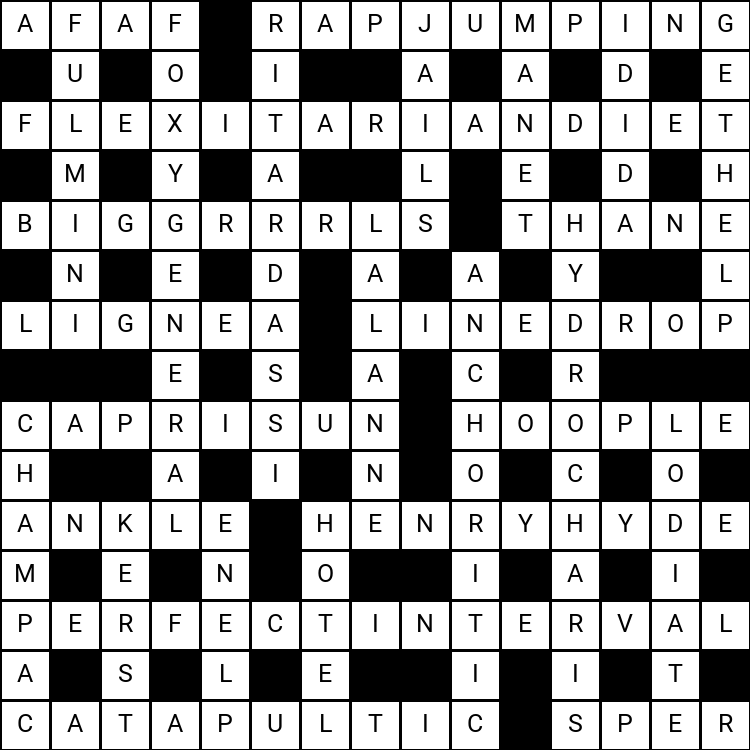

In [ ]:
start_t = time.time()
crossword = Crossword(config['grid'], config['word_list'])
creator = CrosswordCreator(crossword, do_random = True)
assignment = creator.solve()
end_t = time.time()

print("Total time taken: ", end_t - start_t, 'seconds')
print("Total back-tracks: ", creator.back_track_count)
print("Total time taken in revise function: ", creator.t_revise_time)
print("Total times revise function is called: ", creator.t_revise_called)
print("Total time in consistency check: ", creator.consistency_elapsed_time)
# pprint(assignment)

if assignment is not None:
    display(creator.display_only_grid(assignment, block_size = 50, f_size = 25))

In [ ]:
creator.consistency_elapsed_time, creator.consistency_called, creator.back_track_count, creator.t_revise_called

(15.17756700515747, 254796, 254797, 25733)

In [7]:
CA_DATASET = "/content/gdrive/MyDrive/Clue-Answer Dataset/Clue-Answer-Dataset_Version_2.csv"

clue_answer_df = pd.read_csv(CA_DATASET)
clue_answer_df['Unsegmented'] = clue_answer_df['Segmented Answer'].apply(lambda x: str(x).replace(' ', ''))
clue_answer_df.head()

,Unnamed: 0,Clue,Answer,Segmented Answer,answer_length,Unsegmented
0,0,cpa for example crossword clue,taxpro,tax pro,6.0,taxpro
1,1,cordial crossword clue,warm,warm,4.0,warm
2,2,joe without jolt crossword clue,decaf,decaf,5.0,decaf
3,3,bouillabaisse bit crossword clue,mussel,mussel,6.0,mussel
4,4,pre-gps travel aid crossword clue,aaamap,aaa map,6.0,aaamap


In [8]:
def get_grid_nums(grid):
    rows = len(grid)
    cols = len(grid[0])

    mask_grid = [[0] * rows for col in range(cols)]

    for i in range(rows):
        for j in range(cols):
            if config['grid'][i][j] == '':
                mask_grid[i][j] = 'B'

    temp_grid = copy.deepcopy(mask_grid)

    for i in range(rows):
        for j in range(cols):
            if (i - 1) == -1 or (j - 1) == -1:
                if mask_grid[i][j] != 'B':
                    temp_grid[i][j] = 8
            elif temp_grid[i][j] == 'B':
                continue
            elif mask_grid[i - 1][j] == 'B' or mask_grid[i][j - 1] == 'B':
                temp_grid[i][j] = 8

    count = 1
    for i in range(rows):
        for j in range(cols):
            if temp_grid[i][j] == 8:
                temp_grid[i][j] = count
                count += 1

    return temp_grid

def get_answers_by_letters(grid):
    answer_grid = copy.deepcopy(grid)
    for var, answer in assignment.items():
        if var.direction == 'across':
            for i in range(len(answer)):
                answer_grid[var.i][var.j + i] = answer[i]

        elif var.direction == 'down':
            for i in range(len(answer)):
                answer_grid[var.i + i][var.j] = answer[i]
    return answer_grid

def get_clues(grid_nums, assignment):
    across_clues = []
    down_clues = []

    for var, answer in assignment.items():
        relevant_clues = clue_answer_df[clue_answer_df['Unsegmented'] == answer.lower()]['Clue'].tolist()

        if len(relevant_clues) == 0:
            clue = '-NOCLUE-'
        else:
            clue = random.choice(relevant_clues)
        if var.direction == 'across':
            across_clues.append((grid_nums[var.i][var.j], clue.capitalize()))
        else:
            down_clues.append((grid_nums[var.i][var.j], clue.capitalize()))

    across_clues.sort(key = lambda x: x[0])
    down_clues.sort(key = lambda x: x[0])
    # across_clues = list(map(lambda x: f"{x[0]}. {x[1]}", across_clues))
    # down_clues = list(map(lambda x: f"{x[0]}. {x[1]}", down_clues))

    return across_clues, down_clues

In [9]:
def display_grid_only(grid, black_cell_str = '*', grid_nums = None, cell_size = 30, gridnum_font_size = 10, filename = None):
    height = len(grid) * cell_size + 1
    width = len(grid[0]) * cell_size + 1

    black_square_color = "black"
    text_color = 'black'

    img = Image.new("RGB", (width, height), "white")
    draw = ImageDraw.Draw(img)

    font = ImageFont.load_default()

    # Adjust font size
    font_size = gridnum_font_size  # Set your desired font size
    font = ImageFont.truetype("/content/gdrive/MyDrive/Crossword Generator/Roboto-Regular.ttf", font_size)

    for row in range(len(grid)):
        for col in range(len(grid[row])):
            x = col * cell_size
            y = row * cell_size
            rect = [(x, y), (x + cell_size, y + cell_size)]

            if grid[row][col] == black_cell_str:
                draw.rectangle(rect, fill = black_square_color)
            else:
                draw.rectangle(rect, outline = "black")
                if grid_nums is not None:
                    if grid_nums[row][col] != 0:
                      draw.text((x + cell_size // 2 - 17, y + cell_size // 2 - 17), str(grid_nums[row][col]), fill=text_color, anchor="mm", font=font)
    if filename is not None:
        out_filename = filename + '-grid-only.png'
        img.save(out_filename)
    display(img)

def display_grid_solution(grid, grid_nums, black_cell_str = '.', answer_grid = None, output_path = None, filename = None):

    black_square_color = 'black'
    text_color = 'black'
    cell_size = 60

    x_offset = 0
    y_offset = 0

    height = len(grid) * cell_size + 1 + 2 * y_offset
    width = len(grid[0]) * cell_size + 1 + 2 * x_offset

    img = Image.new("RGB", (width, height), "white")
    draw = ImageDraw.Draw(img)

    font = ImageFont.load_default()

    # Adjust font size
    font_size = 10  # Set your desired font size
    font_grid_num = ImageFont.truetype("/content/Roboto-Regular.ttf", font_size)
    font_letter = ImageFont.truetype("/content/Roboto-Bold.ttf", 26)

    for row in range(len(grid)):
        for col in range(len(grid[row])):
            x = col * cell_size + x_offset
            y = row * cell_size + y_offset
            rect = [(x, y), (x + cell_size, y + cell_size)]

            if grid[row][col] == black_cell_str:
                draw.rectangle(rect, fill = black_square_color)
            else:
                draw.rectangle(rect, outline = "black")
                if grid_nums[row][col] != 0:
                    draw.text((x + cell_size // 2 - 20, y + cell_size // 2 - 22), str(grid_nums[row][col]), fill = text_color, font = font_grid_num)
                if answer_grid is not None:
                    draw.text((x + cell_size // 2 - 6, y + cell_size // 2 - 12), answer_grid[row][col], fill = text_color, font = font_letter)
    if filename is not None:
        out_filename = filename + '-solution.png'
        img.save(out_filename)
    display(img)


### Generate American-Style Grids of Desired Sizes

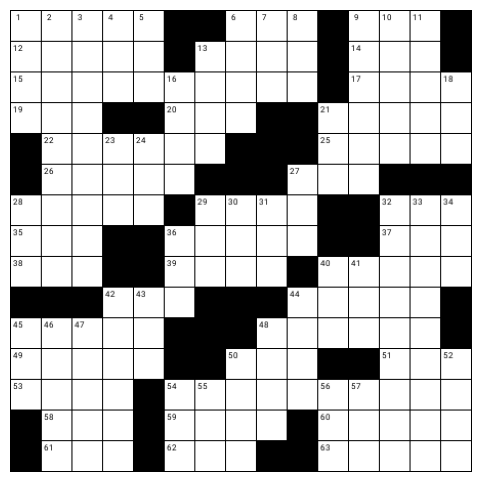

In [68]:
from grid_generator_latest import generate_grid

json_data, symmetry = generate_grid(grid_size = 15, b_factor = 4, display_grid = True)

rows = json_data['size']['rows']
cols = json_data['size']['cols']
grid = json_data['grid']
reshaped_grid = [grid[i:i + rows] for i in range(0, len(grid), rows)]

grid = []
for i in reshaped_grid:
    row = []
    for j in i:
        if j == '.':
            row.append('')
        else:
            row.append('A')
    grid.append(row)
# pprint(grid)

In [ ]:
start_t = time.time()
crossword = Crossword(grid, config['large_word_list'])
creator = CrosswordCreator(crossword, do_random = True)
# creator = CrosswordParallelSolver(crossword, do_random = True)
assignment = creator.solve()
end_t = time.time()
print("Total time taken: ", end_t - start_t, 'seconds')
print("Total back-tracks: ", creator.back_track_count)
print("Total memoized back-tracks: ", creator.memoized_back_track_count)
print("Total time taken in revise function: ", creator.t_revise_time)
print("Total times revise function is called: ", creator.t_revise_called)

if assignment is not None:
    display(creator.display_only_grid(assignment, block_size = 50, f_size = 25))

Before: Domain sizes Arc-Consistency (Pre-Processing Step): 
Cell Position: ((11, 12)) | Direction: ACROSS | Length: 3 --> Domain Size: 6583
Cell Position: ((2, 11)) | Direction: ACROSS | Length: 4 --> Domain Size: 18611
Cell Position: ((4, 1)) | Direction: ACROSS | Length: 6 --> Domain Size: 55930
Cell Position: ((6, 12)) | Direction: DOWN | Length: 9 --> Domain Size: 126259
Cell Position: ((12, 5)) | Direction: ACROSS | Length: 10 --> Domain Size: 132251
Cell Position: ((0, 3)) | Direction: DOWN | Length: 3 --> Domain Size: 6583
Cell Position: ((12, 11)) | Direction: DOWN | Length: 3 --> Domain Size: 6583
Cell Position: ((0, 0)) | Direction: ACROSS | Length: 5 --> Domain Size: 37270
Cell Position: ((5, 9)) | Direction: ACROSS | Length: 3 --> Domain Size: 6583
Cell Position: ((12, 10)) | Direction: DOWN | Length: 3 --> Domain Size: 6583
Cell Position: ((0, 13)) | Direction: DOWN | Length: 5 --> Domain Size: 37270
Cell Position: ((8, 10)) | Direction: ACROSS | Length: 5 --> Domain Size

### Lets get 'Grid only' - 'Grid with Solution' and its associated clues in txt format.

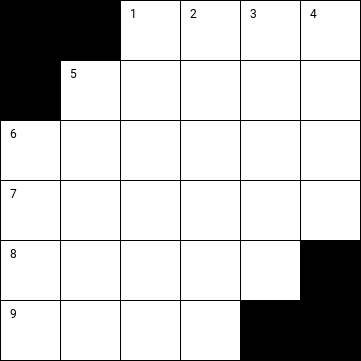

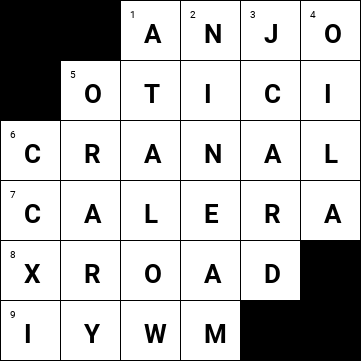

In [59]:
grid_dimension = '6x6'
filename = f'/content/generation results/crossword-{grid_dimension}'
rows = json_data['size']['rows']
cols = json_data['size']['cols']
grid = json_data['grid']
grid_2d = [grid[i:i + rows] for i in range(0, len(grid), rows)]
gridnums_2d = [json_data['gridnums'][i:i + rows] for i in range(0, len(grid), rows)]
answer_2d = creator.letter_grid(assignment)

display_grid_only(grid_2d, black_cell_str = '.', grid_nums = gridnums_2d, cell_size = 60, gridnum_font_size = 12, filename = filename)
display_grid_solution(grid_2d, black_cell_str = '.', grid_nums = gridnums_2d, answer_grid = answer_2d, filename = filename)

In [60]:
across_clues, down_clues = get_clues(gridnums_2d, assignment)

stdout = ''
stdout += 'Across Clues\n'
for clue_num, clue in across_clues:
    stdout += f"{clue_num} {clue}\n"
stdout += '\nDown Clues\n'
for clue_num, clue in down_clues:
    stdout += f"{clue_num} {clue}\n"

txt_out_filename = filename + '-Across-Down-Clues.txt'
with open(txt_out_filename, 'w') as f:
    f.write(stdout)

### A take on British-Style Crosswords

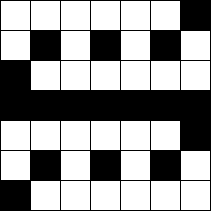

In [21]:
### lets try-out making some british-style grids from above examples
grid_size = 7
rows = cols = grid_size
grid_array = [['A'] * cols for _ in range(rows)]

for row in range(1, rows, 2): # odd_places
    for col in range(1, cols, 2):
        grid_array[row][col] = ''

for i in range(0, ceil(rows / 2)): #even_places
    random_indices = random.sample(range(0, cols), random.randint(1, 3))
    for j in random_indices:
        grid_array[i][j] = ''
        grid_array[rows - 1 - i][cols - 1 - j] = ''

display_grid_only(grid_array, '')

In [ ]:
start_t = time.time()
crossword = Crossword(grid_array, config['word_list'])
creator = CrosswordCreator(crossword, do_random = True)
assignment = creator.solve()
end_t = time.time()

print("Total time taken: ", end_t - start_t, 'seconds')
print("Total back-tracks: ", creator.back_track_count)
print("Total time taken in revise function: ", creator.t_revise_time)
print("Total times revise function is called: ", creator.t_revise_called)
print("Total time in consistency check: ", creator.consistency_elapsed_time)
# pprint(assignment)

if assignment is not None:
    display(creator.display_only_grid(assignment, block_size = 50, f_size = 25))

Before: Domain sizes Arc-Consistency (Pre-Processing Step): 
Cell Position: ((13, 18)) | Direction: DOWN | Length: 8 --> Domain Size: 106961
Cell Position: ((8, 3)) | Direction: ACROSS | Length: 9 --> Domain Size: 126259
Cell Position: ((20, 17)) | Direction: ACROSS | Length: 2 --> Domain Size: 676
Cell Position: ((12, 2)) | Direction: DOWN | Length: 9 --> Domain Size: 126259
Cell Position: ((18, 0)) | Direction: ACROSS | Length: 9 --> Domain Size: 126259
Cell Position: ((4, 0)) | Direction: ACROSS | Length: 15 --> Domain Size: 59741
Cell Position: ((7, 16)) | Direction: DOWN | Length: 2 --> Domain Size: 676
Cell Position: ((4, 16)) | Direction: ACROSS | Length: 5 --> Domain Size: 37270
Cell Position: ((16, 6)) | Direction: ACROSS | Length: 15 --> Domain Size: 59741
Cell Position: ((10, 14)) | Direction: ACROSS | Length: 7 --> Domain Size: 83914
Cell Position: ((1, 4)) | Direction: DOWN | Length: 10 --> Domain Size: 132251
Cell Position: ((14, 1)) | Direction: ACROSS | Length: 3 --> Do

# Create Gif out of Assignment States

In [ ]:
grid_size_info = '13x13'
dir_name = f'/content/Images-{grid_size_info}'
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

for i, state in tqdm(enumerate(creator.states[-150:]), ncols = 150):
    creator.display_only_grid(state, filename = os.path.join(dir_name, f"output_{grid_size_info}-{i}.png"))

150it [00:20,  7.23it/s]


In [ ]:
def sort_by_last_digit(filename):
    last_digit = int(filename.split('-')[-1].split('.')[0])
    return last_digit

def create_gif(images_folder, output_gif_path):
    image_files = sorted([f for f in os.listdir(images_folder) if f.endswith(('.png', '.jpg', '.jpeg', '.gif'))])
    image_files = sorted(image_files, key = sort_by_last_digit)

    images = []
    for image_file in tqdm(image_files, ncols = 50):
        image_path = os.path.join(images_folder, image_file)
        img = Image.open(image_path)
        images.append(img)

    images[0].save(output_gif_path, save_all=True, append_images=images[1:], duration = 300, loop = 0)

# images_folder = "/content/Images"
output_gif_path = f"/content/output {grid_size_info}_1.gif"

create_gif(dir_name, output_gif_path)

100%|█████████| 150/150 [00:00<00:00, 6947.82it/s]


In [ ]:
lines = open("/content/log_info.txt").read().splitlines()
len(lines)

764390

In [ ]:
with open("/content/extracted_data.txt", 'w') as f:
  f.write('\n'.join(lines[:2000]))